# Kanapy
## Analysis of EBSD maps and generation of voxelated RVE

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
January 2024

## 1. Prepare system settings

In [1]:
import kanapy as knpy
import numpy as np


## 2. Analyse EBSD map with MTEX module and determine statistical microstructure descriptors
Microstructure geometry parameters are calculated based on the given EBSD map.
<img alt="EBSD map 316L" src="./ebsd_316L_experiment.png">
<img src="./IPFkey.png" alt="IPF key" style="width:200px">


I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 
  I'm going to colorize the orientation data with the 
  standard MTEX ipf colorkey. To view the colorkey do:
 
  ipfKey = ipfColorKey(ori_variable_name)
  plot(ipfKey)


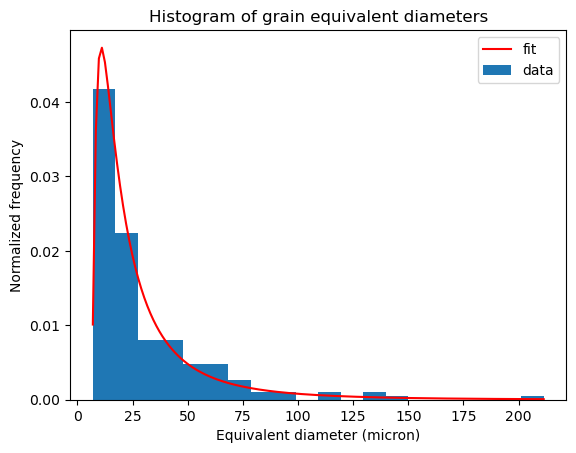

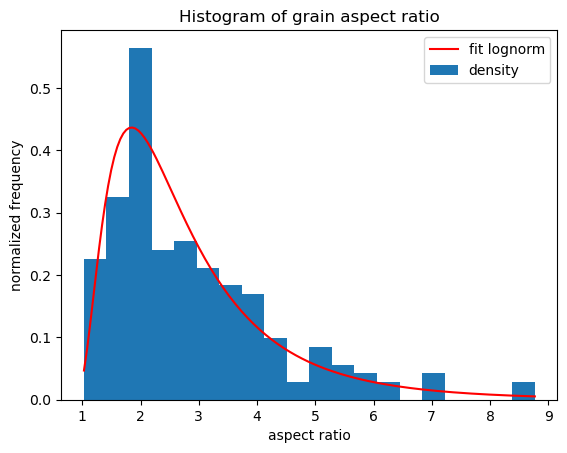

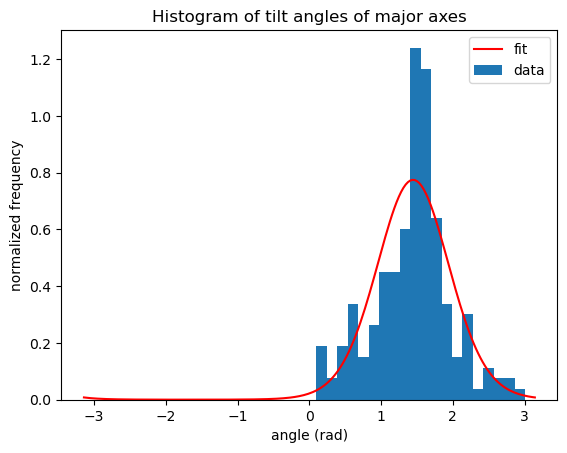

Analyzed microstructure with 183 grains.
Median values: equiv. diameter: 20.179 micron, aspect ratio: 2.469, tilt angle: 82.795°
Std. dev: equivalent diameter: 35.28 micron, aspect ratio: 1.622, tilt angle: 31.003°
*** Statistical information on microstructure ***
=== Phase: iron_fcc ===
==== Grain size (equivalent grain diameter) ====
scale: 13.931, location: 6.248, std. deviation: 1.061
==== Aspect ratio ====
scale: 1.699, location: 0.77, std. deviation: 0.675
==== Tilt angle ====
mean value: 82.795, std. deviation: 232.548


In [2]:
fname = 'ebsd_316L_500x500.ang'  # name of ang file to be imported
if knpy.MTEX_AVAIL:
    # read EBSD map and evaluate statistics of microstructural features
    ebsd = knpy.EBSDmap(fname)
    ms_data = ebsd.ms_data[0]  # analyse only data for majority phase with order parameter "0"
    matname = ms_data['name'].lower().replace(' ', '_')  # material name = MTEX Phase name (lower case and w/o blanks)
    gs_param = ms_data['gs_param']  # parameters for lognorm distr of grain size: [std dev., location, scale]
    ar_param = ms_data['ar_param']  # parameters for lognorm distr. of aspect ratios [std dev., location, scale]
    om_param = ms_data['om_param']  # parameters for normal distribution of ellipsoid tilt angles [std dev., mean]
else:
    # MTEX is not available fall back to predefined values
    print('***Warning: Anaysis of EBSD maps is only possible with an ' +
          'existing MTEX installation in Matlab.')
    print('\nWill continue with predefined settings for microstructure.')
    matname = 'iron_fcc'  # material name
    gs_param = np.array([1.06083584, 6.24824603, 13.9309554])
    ar_param = np.array([0.67525027, 0.76994992, 1.69901906])
    om_param = np.array([0.53941709, 1.44160447])

print('*** Statistical information on microstructure ***')
print(f'=== Phase:', matname, '===')
print('==== Grain size (equivalent grain diameter) ====')
print(f'scale: {gs_param[2].round(3)}, ' +
      f'location: {gs_param[1].round(3)}, ' +
      f'std. deviation: {gs_param[0].round(3)}')
print('==== Aspect ratio ====')
print(f'scale: {ar_param[2].round(3)}, ' +
      f'location: {ar_param[1].round(3)}, ' +
      f'std. deviation: {ar_param[0].round(3)}')
print('==== Tilt angle ====')
print(f'mean value: {(om_param[1] * 180 / np.pi).round(3)}, ' +
      f'std. deviation: {(om_param[0] * 180 / np.pi).round(3)}')

## 3. Generate representative volume element (RVE)
In this part, a representative volume element (RVE) is generated based on the experimental input data.

**Step 1:** To generate the statistics dictionary required by Kanapy, the `set_stats()` method is called with arguments defineing the statistical descriptors for grain size, aspect ratio and omega parameters as determined from the EBSD map. Other parameters need to be set manually. They include lower and upper cutoff values for distributions of equivalent diameters (`deq_min`, `deq_max`), aspect ration (`asp_min`, `asp_max`) and tilt angle (`omega_min`, `omega_max`). Furthermore, the number of voxels (`voxels`), side length of RVE (`size`), its periodicity (`periodicity`), and volume fraction, phase name and number (`VF`, `phasename`, and `phasenum`) need to be specified.


In [3]:
# create dictionary with statistical information obtained from EBSD map
Nv = 30  # number of voxels per side
size = 50  # side length of generated RVE in micron
periodic = True  # create periodic RVE
ms_stats = knpy.set_stats(gs_param, ar_param, om_param,
                          deq_min=8.0, deq_max=19.0, asp_min=0.95, asp_max=3.5,
                          omega_min=0.0, omega_max=2*np.pi, voxels=Nv, size=size,
                          periodicity=periodic,
                          VF=1.0, phasename=matname, phasenum=0)
print('*** Statistical microstructure descriptors ***')
ms_stats

*** Statistical microstructure descriptors ***


{'Grain type': 'Elongated',
 'Equivalent diameter': {'sig': 1.0608358423745927,
  'loc': 6.248246032543533,
  'scale': 13.93095540030784,
  'cutoff_min': 8.0,
  'cutoff_max': 19.0},
 'RVE': {'sideX': 50, 'sideY': 50, 'sideZ': 50, 'Nx': 30, 'Ny': 30, 'Nz': 30},
 'Simulation': {'periodicity': 'True', 'output_units': 'um'},
 'Phase': {'Name': 'iron_fcc', 'Number': 0, 'Volume fraction': 1.0},
 'Aspect ratio': {'sig': 0.6752502663267109,
  'loc': 0.7699499245814801,
  'scale': 1.6990190606888746,
  'cutoff_min': 0.95,
  'cutoff_max': 3.5},
 'Tilt angle': {'kappa': 4.058729520995422,
  'loc': 1.4450526167733555,
  'cutoff_min': 0.0,
  'cutoff_max': 6.283185307179586}}

**Step 2:** Using the `Microstructure` class of Kanapy, a microstructure object is generated, by passing the microstructure descriptors 'ms_stats' obtained from the EBSD analysis as input data to this class. The Python dictionary 'ms_stats' also contains the geometrical definition of the RVE box. After this, the method `plot_stats_init()` plots the statistical distributions that will be used for the particle simulation. The experimental histogram of grain size and aspect ratio distributions are passed as argument 'gs_data' and 'ar_data'. In this case, the size distribution of the grains in the microstructure (orange bars) is fitted by a log-normal distribution (blue line). Finally, the method `init_RVE()` creates the particle set that fulfills the required size distribution within the given lower (dashed vertical line) and upper (solid vertical line) bound.

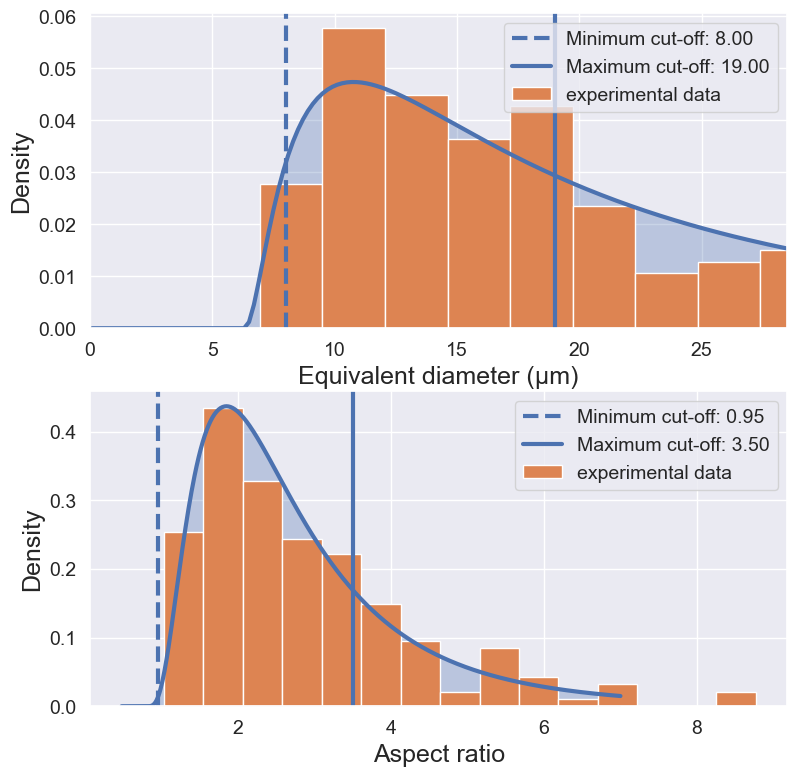

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of particles  = 55
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (50, 50, 50) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.6667 1.6667 1.6667](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: iron_fcc (100.0%)


    Generating voxels inside RVE


In [4]:
# Create box with ellipsoids that represent future grains
ms = knpy.Microstructure(descriptor=ms_stats, name=matname+'_RVE')
if knpy.MTEX_AVAIL:
    ms.plot_stats_init(gs_data=ms_data['gs_data'], ar_data=ms_data['ar_data'])
else:
    ms.plot_stats_init()
ms.init_RVE()

**Step 3:** Perform the particle simulation by invoking the method `pack()`. To accomplish this, the particles generated in the last step are initally downscaled in size by a factor of 100 such that they can move freely through the simulation box but still fulfill the same charactistics of the size distribution with larger and smaller particles in the desired quantities. To avoid overlap of particles, collsions are considered. In this way, the particles form a realistic distribution within the space of the simulation box, as can be verified in the plot by `plot_ellipsoids()`.

Starting particle simulation
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:17<00:00, 40.82it/s]


Completed particle packing
128 overlapping particles detected after packing
Kinetic energy of particles after packing: 14.155265025664173
Initial kinetic energy: 14.155265025664173



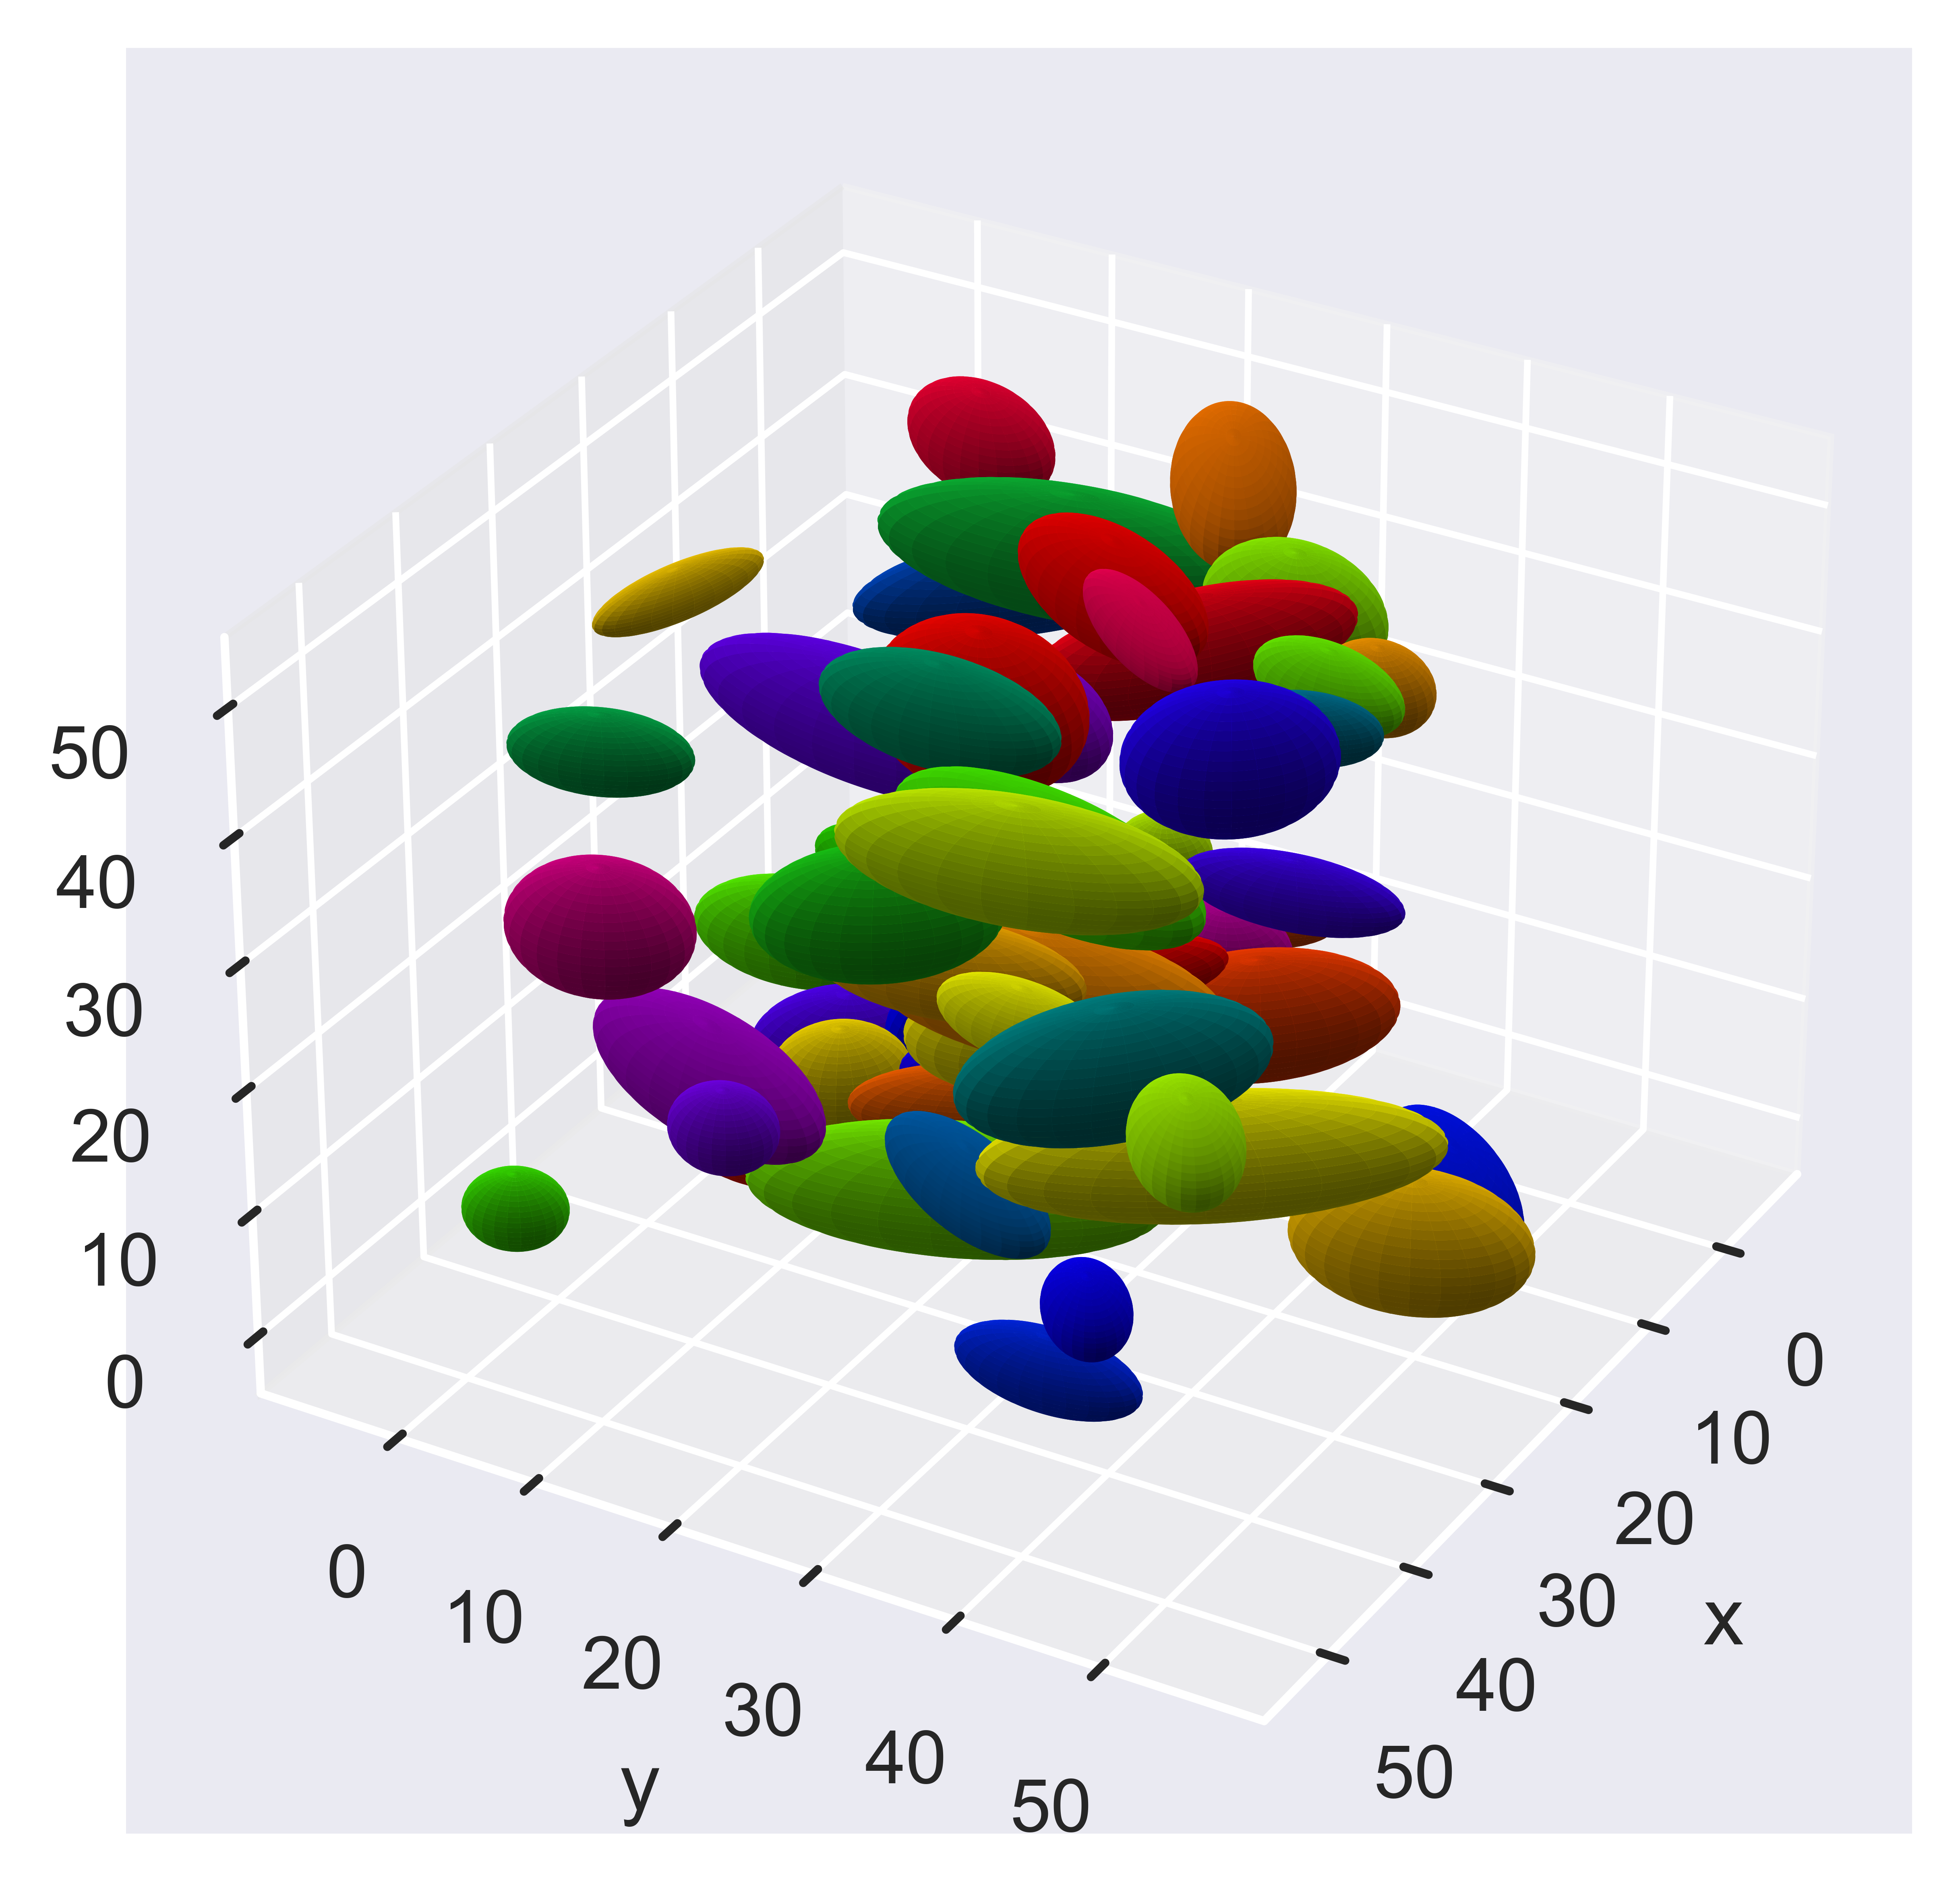

In [5]:
ms.pack()
ms.plot_ellipsoids()

**Step 4:** After the generationof the particle distribution of the desired volume fraction and fulfilling the experimentally found statistical distribution of larger and smaller particles, the method `voxelize()` generates a voxelated structure in form of a regular 3D mesh of the simulation box. Each voxel lying inside a WC particle will be assigned to this phase, all remaining voxels will be considered as Co binder phase. The desired volume fraction of the majority phase WC is provided as argument 'vf'. This procedure generates a representative volume element (RVE) of the cemented carbide, where the WC and Co phase have approximately the experimental volume fractions and a realistic size distribution of the WC particles. In the figure, created by the `plot_voxels()` method, the individual grains are represented in arbitrary colors.


Starting RVE voxelization
    Assigning voxels to grains


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 23666919.12it/s]


Completed RVE voxelization



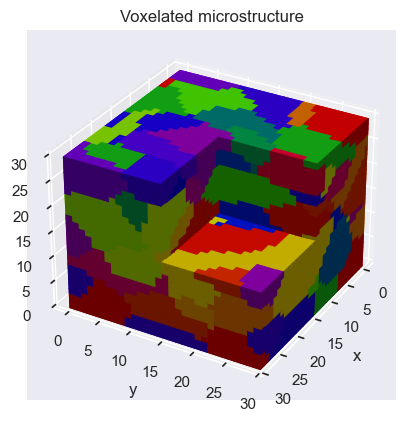

In [6]:
# Create voxel structure and assign each voxel to a grain according to ellipsoids
ms.voxelize()
ms.plot_voxels(sliced=True)

**Step 5:** The grain geometry in the voxelized 3D microstructure (representative volume element, RVE) will be analysed statistically with respect to the grain size distribution and the aspect ratio distribution. This is accomplished by performing the `generate_grains()` method of the microstructure object, which performs a Delaunay tesseleation of the voxel structure by which a ployhedral hull arounf each grain is constructed.  
After that, the experimental data contained in the ebsd object are passed to the `plot_stats()` method for plotting expiermental data together with the grain statistics of the RVE. 


Generated Delaunay tesselation of grain vertices.
Assigning 1802 tetrahedra to grains ...


1802it [01:26, 20.92it/s]


Finished generating polyhedral hulls for grains.
Total volume of RVE: 125000 um^3
Total volume of polyhedral grains: 124999.99999999999 um^3
Mean relative error of polyhedral vs. voxel volume of individual grains: 0.211
for mean volume of grains: 2272.727 um^3.

Computing the L1-error between input and output diameter distributions.
    L1 error phase 0 between particle and grain geometries: 0.47273


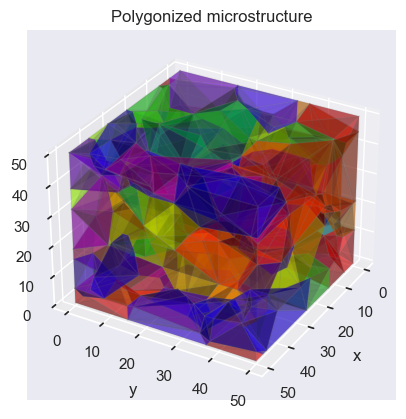

Plotting input & output statistics for phase 0


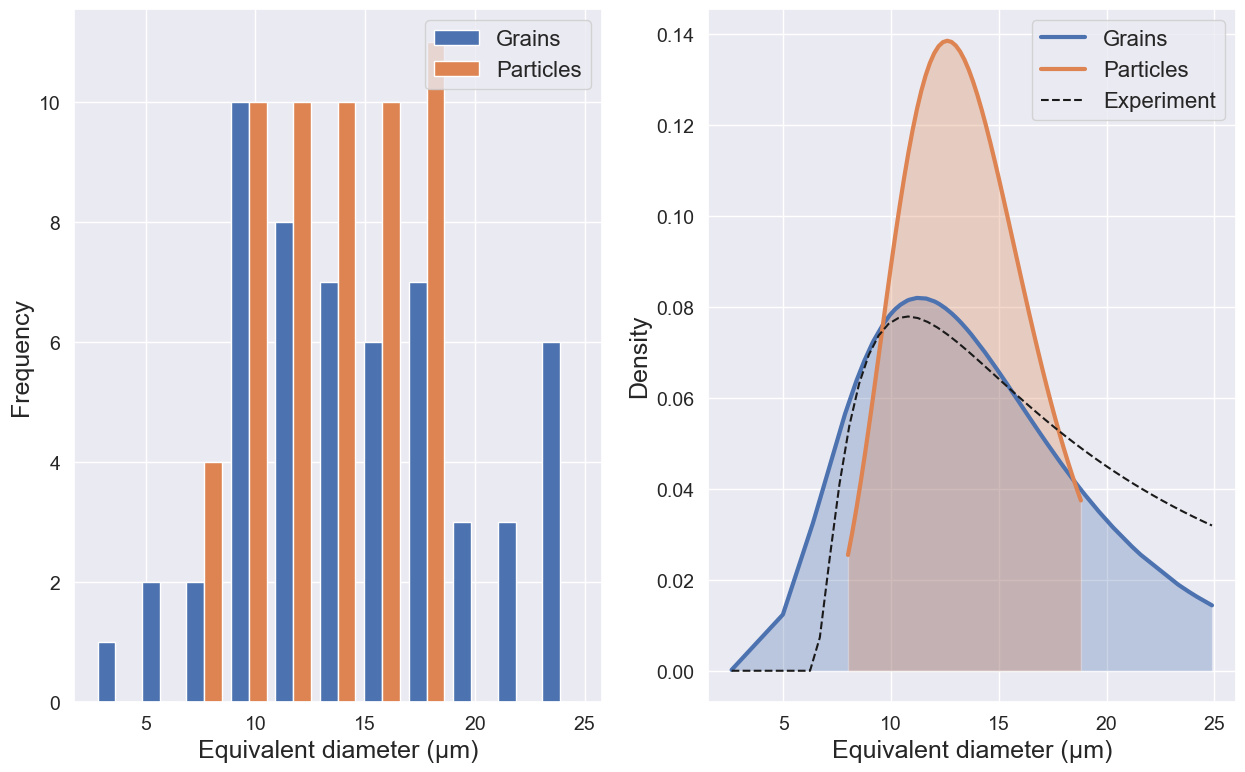

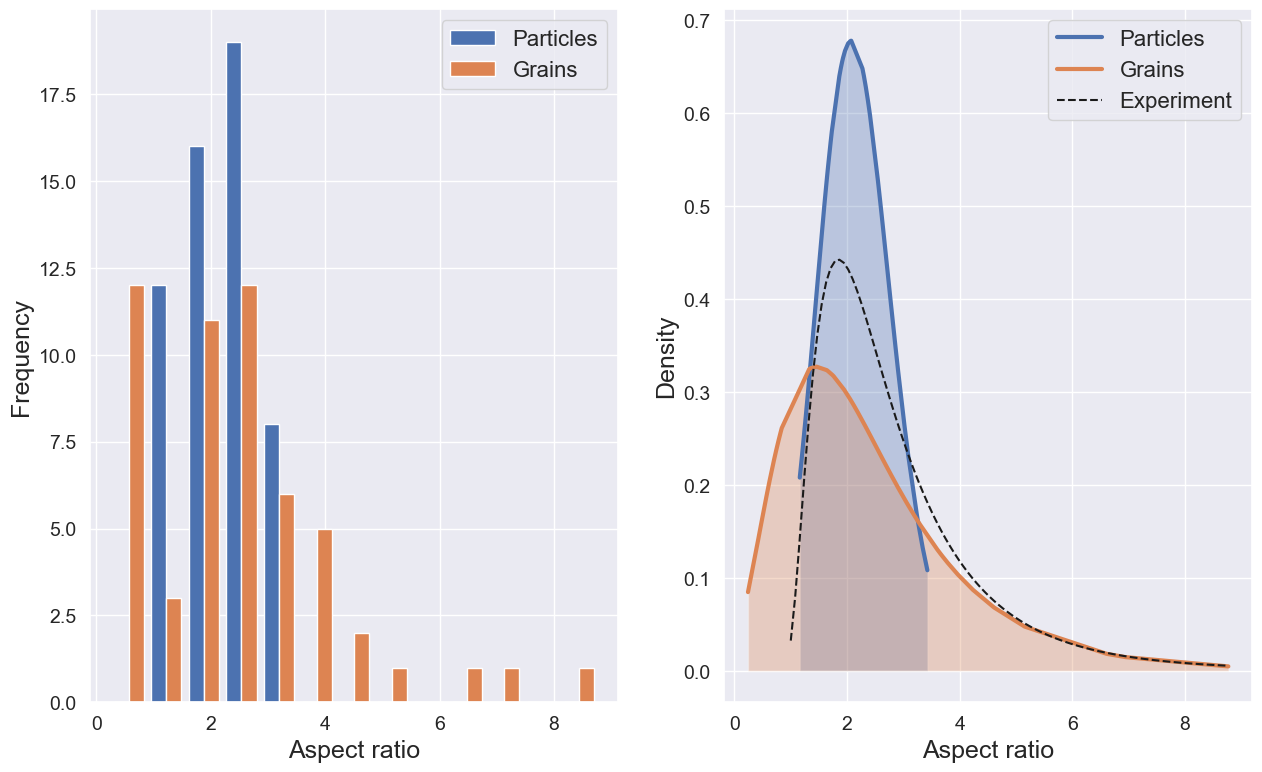

In [7]:
# Create polygonized structure for voxelized grains and analyse statistics of synthetic microstructure
ms.generate_grains()
ms.plot_grains()
if knpy.MTEX_AVAIL:
    ms.plot_stats(gs_param=ms_data['gs_param'], ar_param=ms_data['ar_param'])
else:
    ms.plot_stats()

## 4. Export RVE and grain orientation as Abaqus input files
The geometrical information of the RVE can be directly exported as Abaqus input file with the ending "_geom.inp", which defines a finite element for each voxel. Furthermore, for each grain a set of elements is defined and assigned to a user defined material with the name "GRAIN{grain_id}_MAT".

In [8]:
# write Abaqus input file for voxelated structure
ptag = 'pbc' if periodic else 'non-pbc'
ftrunc = f'from_ebsd_vox{Nv}_gr{ms.Ngr}_{ptag}'
ms.write_abq(nodes='v', file=ftrunc+'_geom.inp')


Writing RVE as ABAQUS file "./from_ebsd_vox30_gr55_pbc_geom.inp"
Using brick element type C3D8.
---->DONE!



'./from_ebsd_vox30_gr55_pbc_geom.inp'

Finally, information on the grain orientations is also exported as Abaqus input file with the ending "_mat.inp". This file contains the information on the material number to be used in the ICAMS Crystal Plasticity UMAT and the Euler angles for each grain, identified by the name "GRAIN{grain_id}_MAT".

In [9]:
if not knpy.MTEX_AVAIL:
    ori_rve = None
    raise ModuleNotFoundError('Generation of grain orientation sets is only possible with an existing MTEX installation in Matlab.')
    
# get list of orientations for grains in RVE matching the ODF of the EBSD map
ori_rve = ebsd.calcORI(ms.Ngr, shared_area=ms.geometry['GBarea'])

# write Euler angles of grains into Abaqus input file
matnumber = 4  # material number of austenite for CP UMAT
knpy.writeAbaqusMat(matnumber, ori_rve, file=ftrunc+'_mat.inp')

Optimum kernel estimated from mean orientations of grains
 estimating optimal kernel halfwidth: 0%
 estimate optimal kernel halfwidth: 10%
 estimate optimal kernel halfwidth: 20%
 estimate optimal kernel halfwidth: 30%
 estimate optimal kernel halfwidth: 40%
 estimate optimal kernel halfwidth: 50%
 estimate optimal kernel halfwidth: 60%
 estimate optimal kernel halfwidth: 70%
 estimate optimal kernel halfwidth: 80%
 estimate optimal kernel halfwidth: 90%
 estimate optimal kernel halfwidth: 100%

time =

   28.1091


e =

    0.1955


e =

    0.1877


e =

    0.1872


e =

    0.1828


e =

    0.1616


e =

    0.1480


e =

    0.1434


e =

    0.1406


e =

    0.1399


e =

    0.1139


e =

    0.1133


e =

    0.1057


e =

    0.1009


e =

    0.1000


e =

    0.0820


e =

    0.0759


e =

    0.0726


e =

    0.0635


e =

    0.0566


e =

    0.0559


e =

    0.0500


e =

    0.0498


time =

    2.2095



**Note 1:** To generate a valid Abaqus model the {}_geom.inp and {}_mat.inp files need to be imported directly into Abaqus CAE or included into a generic Abaqus deck (.inp file) via "*INCLUDE" commands. 

**Note 2:** An Abaqus model with periodic boundary conditions can be generated by executing the Python script "Create_PeriodicBC_EDGE_3D.py" in the form  
`python Create_PeriodicBC_EDGE_3D.py {file_trunc}_geom.inp`  
This generates a subfolder-structure with different files. The resulting periodic geometry can by included into an Abaqus deck via the command "*Include, input=PeriodicData/geometry_Periodic.inp". An example for such an input deck for a periodic structure is avalaible in the file "Fatigue_BC_Amp_05.inp".


**Optional step: Safe voxelized structure (re-entry point upon restart)**
The voxel structure achived at this point can be stored as JSON file that contains all information on the voxels and the phase distribution of the microstructure. This file can be used to skip the time-consuming packing simulation in case the notebook has to be executed again. In that case, simply import the voxel structure with `knpy.import_voxels(file)` after the initialization and reading the EBSD map.


In [10]:
# Save Kanapy microstructure as voxel file
ms.write_voxels(file=f'{matname}_voxels.json', angles=ori_rve, script_name='ebsd2rve.ipynb', mesh=False, system=False)

Writing voxel information of microstructure to ./iron_fcc_voxels.json.
